In [3]:
pip install git+https://github.com/pymc-devs/pymc3

  Cloning https://github.com/pymc-devs/pymc3 to c:\users\sidha\appdata\local\temp\pip-req-build-lrirsku6
  Created wheel for pymc3: filename=pymc3-3.8-cp37-none-any.whl size=1872108 sha256=de431c9e37549702801747bd78b6e142c31a13d7386e632d21432251f0c9c614
  Stored in directory: C:\Users\sidha\AppData\Local\Temp\pip-ephem-wheel-cache-k5asln3u\wheels\a1\e3\71\a696f2af0dd40bccc0ce672d616d21cc9dd90dbdd3f03242f4
Successfully built pymc3
Note: you may need to restart the kernel to use updated packages.


  Running command git clone -q https://github.com/pymc-devs/pymc3 'C:\Users\sidha\AppData\Local\Temp\pip-req-build-lrirsku6'


In [1]:
%matplotlib inline

from pymc3 import  *

import numpy as np
import matplotlib.pyplot as plt

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\sidha\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pandas as pd
np.random.seed(42)
import seaborn as sns
from IPython.core.pylabtools import figsize
from scipy.stats import percentileofscore
from scipy import stats



In [3]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy

In [96]:
#PyMC3 for Bayesian interface
import pymc3 as pm


### We are using data on student grades collected from a Portuguese secondary (high) school. This data is from the UCI machine learning repository, a great collection of datasets for model testing. The data includes academic and personal characteristics of the students as well as final grades. The objective is to predict the final grade from the student information which makes this a supervised, regression task. We have a set of training data with known labels, and we want the model to learn a mapping from the features (explanatory variables) to the target (the label) in this case the final grade. It is a regression task because the final grade is a continuous value.

In [5]:
df = pd.read_csv('data/student_mat.csv')

In [6]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [7]:
df['G3'].describe()

count    649.000000
mean      11.906009
std        3.230656
min        0.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       19.000000
Name: G3, dtype: float64

In [8]:
df['G3'].value_counts()


11    104
10     97
13     82
12     72
14     63
15     49
16     36
9      35
8      35
17     29
0      15
18     15
7      10
6       3
19      2
5       1
1       1
Name: G3, dtype: int64

In [9]:
# Filter out grades that were 0
df = df[~df['G3'].isin([0, 1])]

df = df.rename(columns={'G3': 'Grade'})

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [10]:
df.shape

(633, 33)

In [11]:
df.describe()


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,Grade
count,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000
mean,16.720379,2.519747,2.320695,1.563981,1.941548,0.206951,3.932070,3.169036,3.184834,1.489731,2.268562,3.527646,3.751975,11.503949,11.756714,12.205371
std,1.214044,1.133497,1.102284,0.750167,0.833284,0.579023,0.946411,1.047082,1.162014,0.912452,1.281776,1.448355,4.662003,2.682645,2.629715,2.656882
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000,5.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,12.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


In [12]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'Grade'],
      dtype='object')

In [13]:
for col in df.columns:
    if df[col].dtype == 'object':
        print('\ncolumn name: ', col)
        print(df[col].value_counts())


column name:  school
GP    421
MS    212
Name: school, dtype: int64

column name:  sex
F    376
M    257
Name: sex, dtype: int64

column name:  address
U    446
R    187
Name: address, dtype: int64

column name:  famsize
GT3    443
LE3    190
Name: famsize, dtype: int64

column name:  Pstatus
T    555
A     78
Name: Pstatus, dtype: int64

column name:  Mjob
other       249
services    135
at_home     131
teacher      70
health       48
Name: Mjob, dtype: int64

column name:  Fjob
other       359
services    175
at_home      41
teacher      35
health       23
Name: Fjob, dtype: int64

column name:  reason
course        279
home          146
reputation    141
other          67
Name: reason, dtype: int64

column name:  guardian
mother    444
father    149
other      40
Name: guardian, dtype: int64

column name:  schoolsup
no     566
yes     67
Name: schoolsup, dtype: int64

column name:  famsup
yes    393
no     240
Name: famsup, dtype: int64

column name:  paid
no     595
yes     38
Nam

In [14]:
df['Grade'].value_counts()

11    104
10     97
13     82
12     72
14     63
15     49
16     36
9      35
8      35
17     29
18     15
7      10
6       3
19      2
5       1
Name: Grade, dtype: int64

Text(0.5, 1.0, 'Distribution of grades')

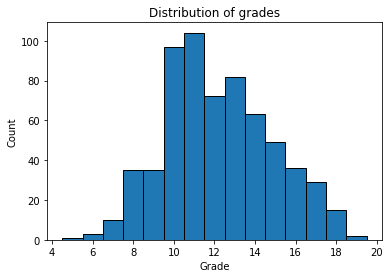

In [15]:
# bar plot for grades
plt.bar(df['Grade'].value_counts().index, 
       df['Grade'].value_counts().values,
       width = 1, edgecolor = 'k')
plt.xlabel('Grade'); plt.ylabel('Count')
plt.title('Distribution of grades')

In [16]:
print(df['Grade'].value_counts().index)
print(df['Grade'].value_counts().values)

Int64Index([11, 10, 13, 12, 14, 15, 16, 9, 8, 17, 18, 7, 6, 19, 5], dtype='int64')
[104  97  82  72  63  49  36  35  35  29  15  10   3   2   1]


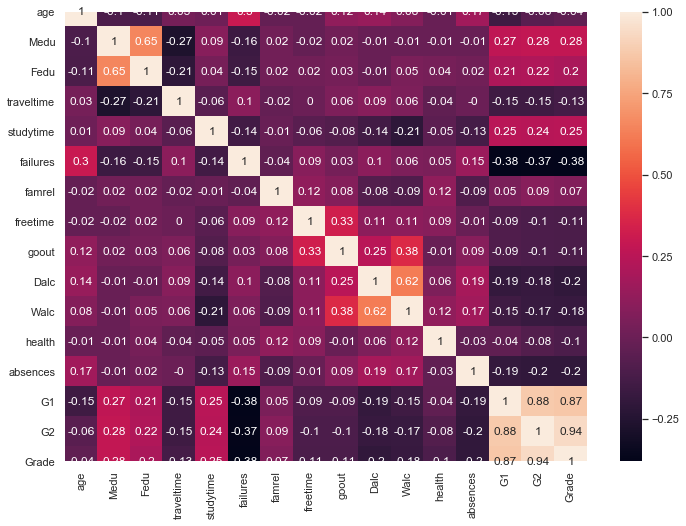

In [17]:
corr_matrix = df.corr().round(2)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(data = corr_matrix, annot = True)

Text(0.5, 1.0, 'density of grades by location')

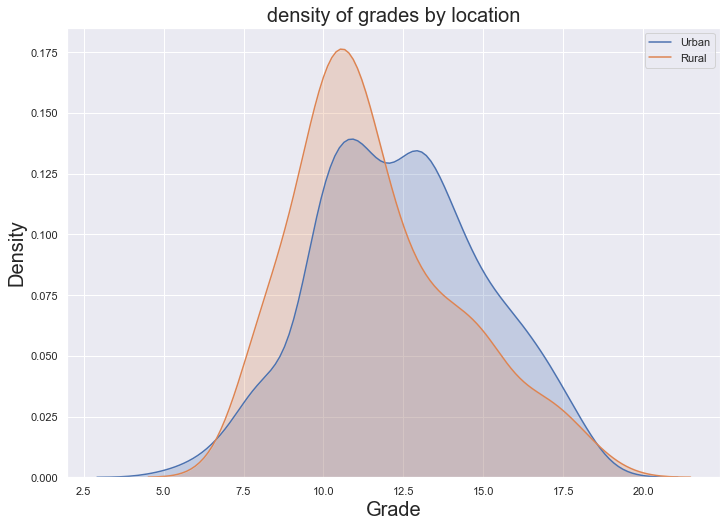

In [18]:
sns.kdeplot(df.loc[df['address'] == 'U', 'Grade'], label = 'Urban', shade = True)
sns.kdeplot(df.loc[df['address'] == 'R', 'Grade'], label = 'Rural', shade = True)
plt.ylabel('Density', size=20)
plt.xlabel('Grade', size = 20)
plt.title('density of grades by location', size = 20)

Text(0, 0.5, 'Density')

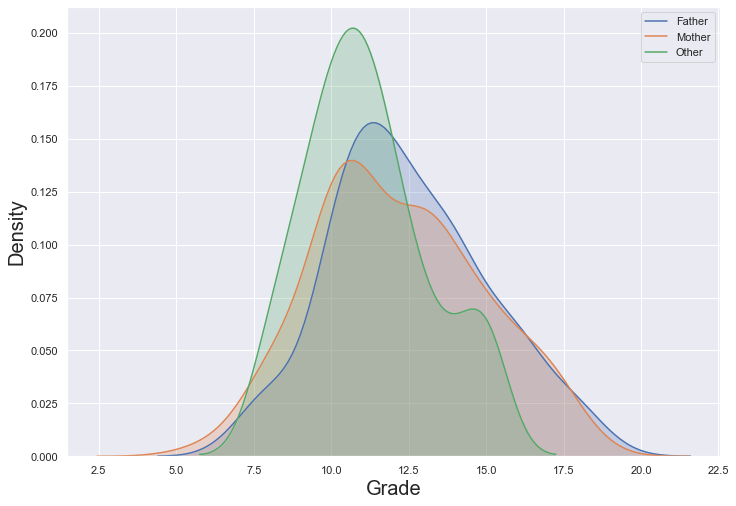

In [19]:
sns.kdeplot(df.loc[df['guardian'] == 'father', 'Grade'], label = 'Father', shade = True)
sns.kdeplot(df.loc[df['guardian'] == 'mother', 'Grade'], label = 'Mother', shade = True)
sns.kdeplot(df.loc[df['guardian'] == 'other', 'Grade'], label = 'Other', shade = True)
plt.xlabel('Grade', size=20)
plt.ylabel('Density', size=20)

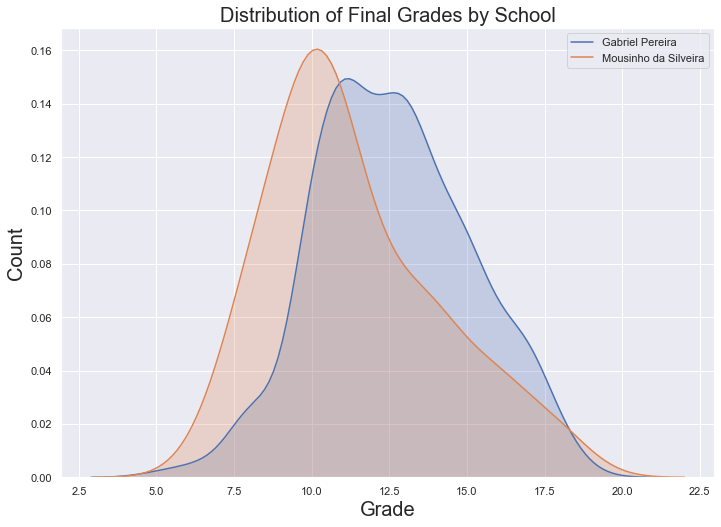

In [20]:
# Grade distribution by school
sns.kdeplot(df.loc[df['school'] == 'GP', 'Grade'], label = 'Gabriel Pereira', shade = True)
sns.kdeplot(df.loc[df['school'] == 'MS', 'Grade'], label = 'Mousinho da Silveira', shade = True)
plt.xlabel('Grade', size=20); plt.ylabel('Count', size=20); plt.title('Distribution of Final Grades by School', size=20);

In [21]:
schools = df.groupby(['school'])['address'].value_counts()
schools

school  address
GP      U          343
        R           78
MS      R          109
        U          103
Name: address, dtype: int64

In [22]:
df.corr()['Grade'].sort_values()

failures     -0.384569
absences     -0.204230
Dalc         -0.196891
Walc         -0.178839
traveltime   -0.129654
goout        -0.111228
freetime     -0.105206
health       -0.096461
age          -0.042505
famrel        0.072888
Fedu          0.204392
studytime     0.249855
Medu          0.278690
G1            0.874777
G2            0.942691
Grade         1.000000
Name: Grade, dtype: float64

In [23]:
category_df = df.select_dtypes('object')
# One hot encode the variables
dummy_df = pd.get_dummies(category_df)
dummy_df['Grade'] = df['Grade']
dummy_df.head()

,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,...,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,Grade
0,1,0,1,0,0,1,1,0,1,0,...,0,0,1,0,1,1,0,1,0,11
1,1,0,1,0,0,1,1,0,0,1,...,0,1,0,0,1,0,1,1,0,11
2,1,0,1,0,0,1,0,1,0,1,...,0,0,1,0,1,0,1,1,0,12
3,1,0,1,0,0,1,1,0,0,1,...,1,0,1,0,1,0,1,0,1,14
4,1,0,1,0,0,1,1,0,0,1,...,0,0,1,0,1,1,0,1,0,13


In [24]:
print(dummy_df.shape)
print(df.shape)

(633, 44)
(633, 33)


In [25]:
# Correlations in one-hot encoded dataframe
dummy_df.corr()['Grade'].sort_values()

higher_no           -0.343742
school_MS           -0.227632
Mjob_at_home        -0.158496
reason_course       -0.138195
internet_no         -0.131408
address_R           -0.128350
sex_M               -0.125755
guardian_other      -0.100802
schoolsup_yes       -0.098185
reason_other        -0.092382
activities_no       -0.078526
paid_yes            -0.067146
nursery_no          -0.056449
romantic_yes        -0.052050
Fjob_at_home        -0.049372
Fjob_services       -0.042497
Mjob_other          -0.035494
Fjob_other          -0.021292
famsize_GT3         -0.012957
guardian_mother     -0.008042
Pstatus_T           -0.001776
famsup_no           -0.001581
famsup_yes           0.001581
Pstatus_A            0.001776
Mjob_services        0.006210
famsize_LE3          0.012957
Fjob_health          0.026320
reason_home          0.046639
romantic_no          0.052050
nursery_yes          0.056449
guardian_father      0.066486
paid_no              0.067146
activities_yes       0.078526
Mjob_healt

In [60]:
def format_data(df):
    labels = df['Grade']
    df  = df.drop(columns = ['school','G1','G2'])
    # one hot encoding of categorical variables
    df = pd.get_dummies(df)
    
    #finding correlation with grade
    most_correlated = df.corr().abs()['Grade'].sort_values(ascending=False)
    
    # taking only top 8 most correlated features
    most_correlated = most_correlated[:8]
    
    df = df.loc[: , most_correlated.index]
    df = df.drop(columns = 'higher_no')

    
    X_train, X_test, y_train, y_test = train_test_split(df, labels, 
                                                        test_size = 0.25,
                                                        random_state=42)
    return X_train, X_test, y_train, y_test, most_correlated

In [61]:
X_train, X_test, y_train, y_test, most_correlated = format_data(df)
X_train.head()


,Grade,failures,higher_yes,Medu,studytime,Fedu,absences
619,13,0,1,3,2,3,6
323,10,0,1,4,1,3,0
201,16,0,1,2,2,1,0
410,17,0,1,2,2,2,0
426,11,0,1,3,1,3,4


In [62]:
print(y_train.shape)
print(X_train.shape)
print(most_correlated)

(474,)
(474, 7)
Grade         1.000000
failures      0.384569
higher_yes    0.343742
higher_no     0.343742
Medu          0.278690
studytime     0.249855
Fedu          0.204392
absences      0.204230
Name: Grade, dtype: float64


In [63]:
# Rename variables in train and teste
X_train = X_train.rename(columns={'higher_yes': 'higher_edu', 
                                  'Medu': 'mother_edu',
                                  'Fedu': 'father_edu'})

X_test = X_test.rename(columns={'higher_yes': 'higher_edu', 
                                  'Medu': 'mother_edu',
                                  'Fedu': 'father_edu'})

In [64]:
X_train.head()


,Grade,failures,higher_edu,mother_edu,studytime,father_edu,absences
619,13,0,1,3,2,3,6
323,10,0,1,4,1,3,0
201,16,0,1,2,2,1,0
410,17,0,1,2,2,2,0
426,11,0,1,3,1,3,4


In [32]:
stats.pearsonr?

C:\Users\sidha\Anaconda3\lib\site-packages\matplotlib\contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\sidha\Anaconda3\lib\site-packages\matplotlib\contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\sidha\Anaconda3\lib\site-packages\seaborn\distributions.py:423: UserWarning: No contour levels were found within the data range.
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


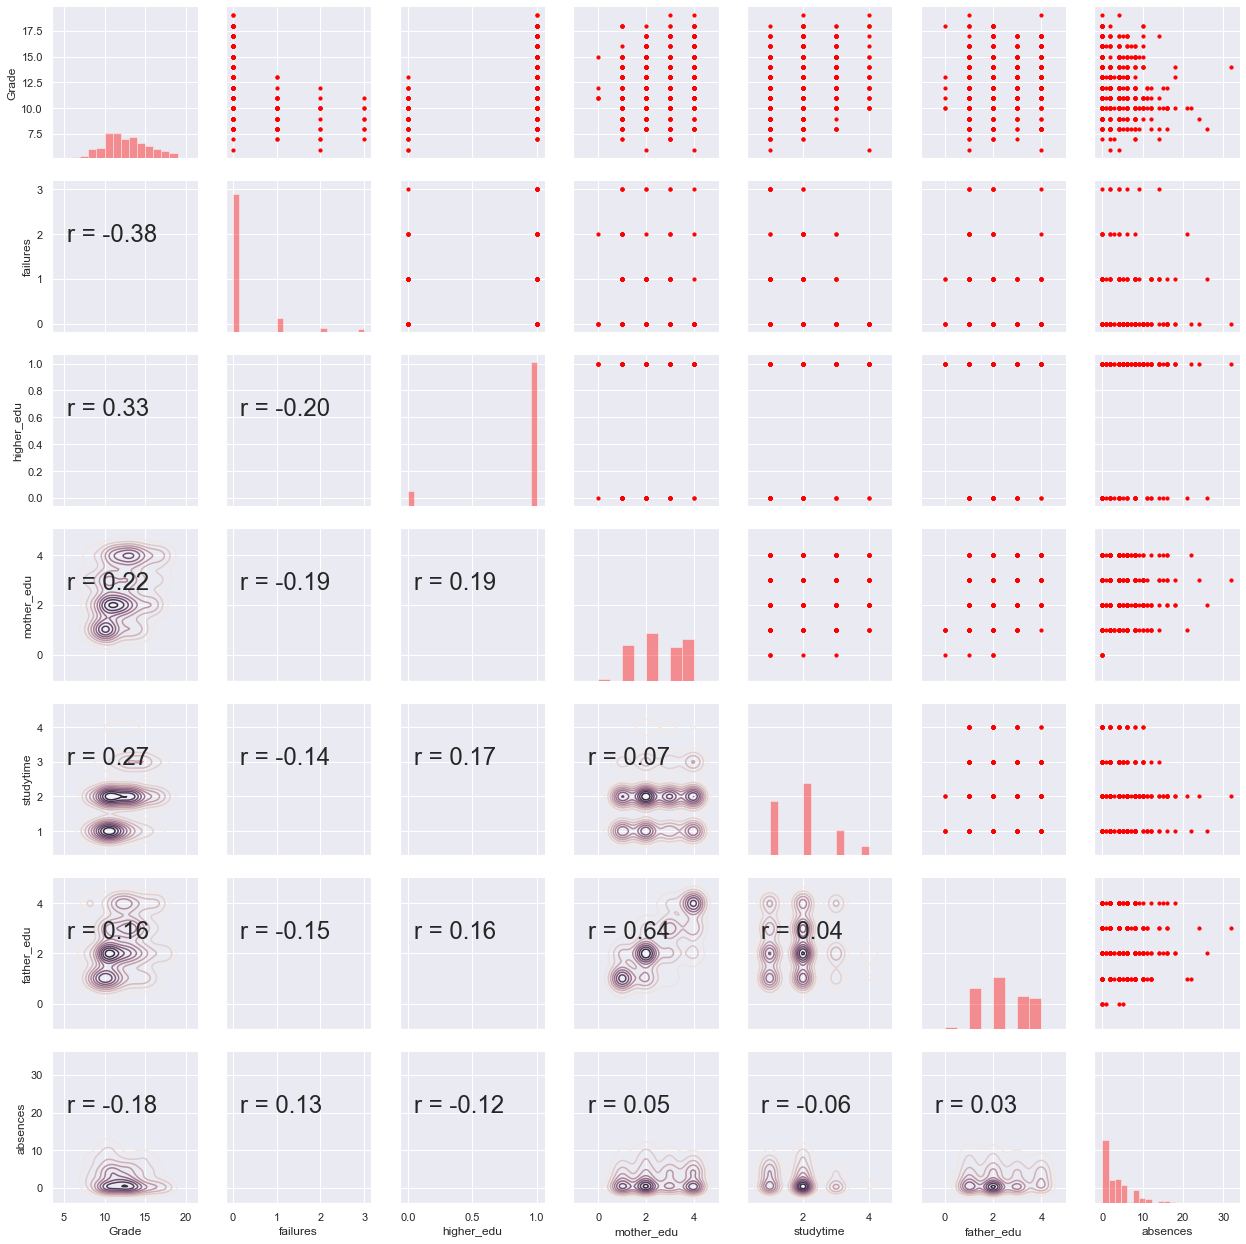

In [65]:

# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(X_train)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [66]:
X_plot = X_train
X_plot.head()

,Grade,failures,higher_edu,mother_edu,studytime,father_edu,absences
619,13,0,1,3,2,3,6
323,10,0,1,4,1,3,0
201,16,0,1,2,2,1,0
410,17,0,1,2,2,2,0
426,11,0,1,3,1,3,4


In [67]:
# Create relation to the median grade column
X_plot['relation_median'] = (X_plot['Grade'] >= 12)
#print(X_plot.head())
X_plot['relation_median'] = X_plot['relation_median'].replace({True: 'above', False: 'below'})
X_plot = X_plot.drop(columns='Grade')
X_plot.head()

,failures,higher_edu,mother_edu,studytime,father_edu,absences,relation_median
619,0,1,3,2,3,6,above
323,0,1,4,1,3,0,below
201,0,1,2,2,1,0,above
410,0,1,2,2,2,0,above
426,0,1,3,1,3,4,below


In [68]:
print(X_plot.columns)
print(enumerate(X_plot.columns[:-1]))

Index(['failures', 'higher_edu', 'mother_edu', 'studytime', 'father_edu',
       'absences', 'relation_median'],
      dtype='object')



 0 failures
619    0
201    0
410    0
544    0
270    0
      ..
121    0
20     0
272    0
437    0
102    0
Name: failures, Length: 262, dtype: int64

 1 higher_edu
619    1
201    1
410    1
544    1
270    1
      ..
121    1
20     1
272    1
437    1
102    1
Name: higher_edu, Length: 262, dtype: uint8

 2 mother_edu
619    3
201    2
410    2
544    1
270    4
      ..
121    2
20     4
272    1
437    0
102    4
Name: mother_edu, Length: 262, dtype: int64


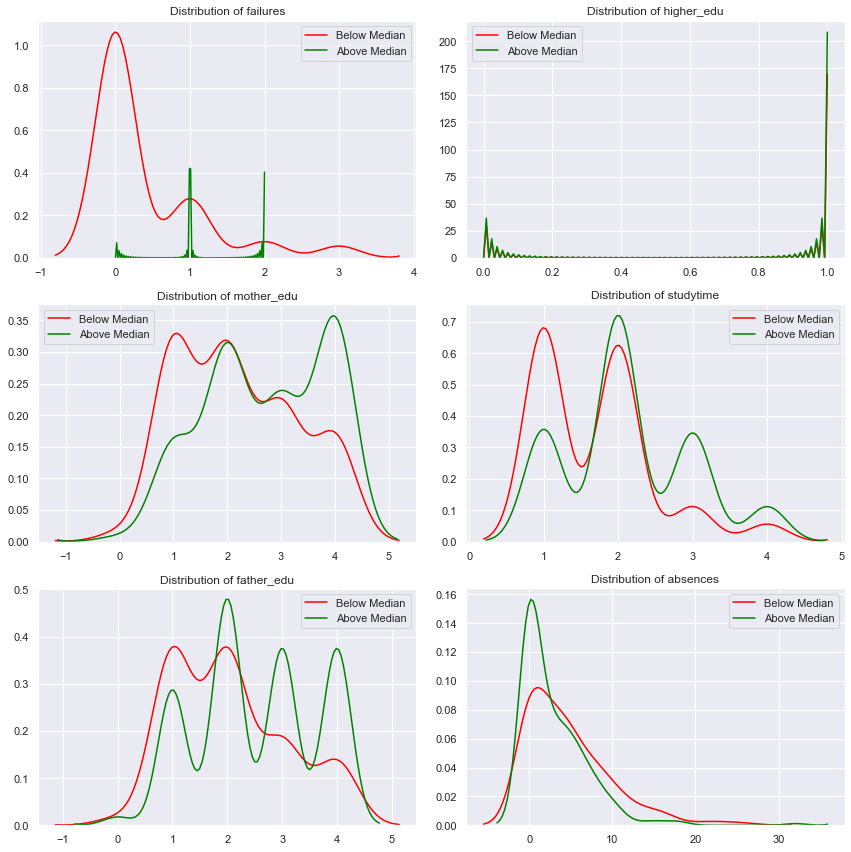

In [92]:

plt.figure(figsize=(12, 12))
# Plot the distribution of each variable colored
# by the relation to the median grade
for i, col in enumerate(X_plot.columns[:-1]):
    #print(i)
    plt.subplot(3, 2, i + 1)
    subset_above = X_plot[X_plot['relation_median'] == 'above']
    subset_below = X_plot[X_plot['relation_median'] == 'below']
    if i < 3:
        print('\n',i, col)
        #print(X_plot.groupby(['relation_median'])[col].value_counts())
        print(subset_above[col])
    sns.kdeplot(subset_below[col], label = 'Below Median', color = 'red')
    sns.kdeplot(subset_above[col], label = 'Above Median', color = 'green')
    #sns.kdeplot(subset_below[col], label = 'Below Median', color = 'red')
    plt.legend(); plt.title('Distribution of %s' % col)
    
plt.tight_layout()


In [82]:
# Calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    
    return mae, rmse

# Naive Baseline

#### For a regression task, a simple naive baseline is to guess the median value on the training set for all testing cases. If our machine learning model cannot better this simple baseline, then perhaps we should try a different approach!

In [94]:
median_pred = X_train['Grade'].median()
median_preds = [median_pred for _ in range(len(X_test))]
true = X_test['Grade']
# Display the naive baseline metrics
mb_mae, mb_rmse = evaluate_predictions(median_preds, true)
print('Median Baseline  MAE: {:.4f}'.format(mb_mae))
print('Median Baseline RMSE: {:.4f}'.format(mb_rmse))
print(len(median_preds))
print((X_train.shape))
print(X_test.shape)

Median Baseline  MAE: 2.1761
Median Baseline RMSE: 2.6777
159
(474, 8)
(159, 7)


In [89]:
X_train.head()

,Grade,failures,higher_edu,mother_edu,studytime,father_edu,absences,relation_median
619,13,0,1,3,2,3,6,above
323,10,0,1,4,1,3,0,below
201,16,0,1,2,2,1,0,above
410,17,0,1,2,2,2,0,above
426,11,0,1,3,1,3,4,below


In [91]:
#X_plot.groupby(['relation_median'])[col].value_counts()
X_train['higher_edu'].value_counts()

1    428
0     46
Name: higher_edu, dtype: int64

## Create model in PyMC3 and sample from Posterior

In [97]:
# context for the model
with pm.Model() as normal_model:
    print(pm.Model())